In [1]:
import numpy as np
import matplotlib.pyplot as plt   
from scipy import stats
import os
import random
import re
from skbio.diversity.alpha import *

In [3]:
path='/home/etienne/data/dataXetien/'
path2='/home/etienne/data/target_dir/'
remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]

In [24]:
def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1) 
    gz=stats.zscore(tseries,nan_policy='omit')
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def reg_measure(Bold_sim,n=1):
    V=np.var(Bold_sim,axis=0)
    S=np.sum(V[np.argsort(V)[-n::]])
    return(S)

def triangle_measure(Bold_sim):
    C=np.corrcoef(go_edge(Bold_sim))
    T=C[np.triu_indices(C.shape[0],k=1)]
    var=np.var(T)
    return(var)

def simpsonbis(Bold_sim):
    C=(np.corrcoef(go_edge(Bold_sim)))
    T=C[np.triu_indices(C.shape[0],k=1)]
    if np.isnan(T).any():
        return(0)
    I=np.unique(np.around(T,decimals=2),return_counts=True)
    return(simpson(I[1]))

def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def common_hubs(B1,B2,n=8):
    hub1=functional_hub(B1,nregions=n)
    hub2=functional_hub(B2,nregions=n)
    return(np.intersect1d(hub1,hub2))

def best_sim(Msim,Bold,n=8):
    hub=functional_hub(Bold,nregions=n)
    m=Msim.shape[0]
    p=Msim.shape[1]
    C=np.zeros((m,p))
    for k in range(m):
        for l in range(p):
            C[k,l]=len(np.intersect1d(Msim[k,l,:],hub))
    return(np.argwhere(C == np.amax(C)),np.amax(C))

def predictive_power(B1,B2):
    FC1=np.corrcoef(B1.T)
    FC2=np.corrcoef(B2.T)
    T1=FC1[np.triu_indices(FC1.shape[0],k=1)]
    T2=FC2[np.triu_indices(FC2.shape[0],k=1)]
    if np.isnan([FC1,FC2]).any():
        return([0,0])
    return(stats.pearsonr(T1,T2))

def best_PP(Bold,Bsim):
    m=Bsim.shape[0]
    p=Bsim.shape[1]
    M=np.zeros((m,p))
    for k in range(m):
        for j in range(p):
            M[k,j]=predictive_power(Bold,Bsim[k,j,:,:])[0]
    return(np.argwhere(M == np.amax(M)),np.amax(M))

def RSS(Bold):
    return(np.sqrt(np.sum(go_edge(Bold)**2,axis=1)))

In [9]:
data=np.load(path+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(34))
Blen=data.shape[0]
nregions=data.shape[1]-len(remove_roi)
B=np.zeros((8,Blen,nregions))
i=0
for k in [34,36,38,40,41,42,43,44]:
    bold=np.load(path+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(k))
    bold=np.delete(bold,remove_roi,axis=1)
    B[i,:,:]=bold
    i+=1

In [10]:
G=np.array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ,
       0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51,
       0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62,
       0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73,
       0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84,
       0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95,
       0.96, 0.97])
N=np.array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 ])

Blen=1500
nregions=148

Bsim=np.zeros((len(G),len(N),Blen,nregions))
for iig, ig in enumerate(G):
    for ii, i in enumerate(N):
        #print('mpr_mouse_A148_G' +str(ig)+'_nsigma' +str(i)+'_alpha0.0.npz')
        bold=np.load(path2+'mpr_mouse_A148_G' +str(ig)+'_nsigma' +str(i)+'_alpha0.0.npz')['Bold_data'][-Blen:,0,:]
        if True not in np.unique(np.isnan(bold)):
            Bsim[iig,ii,:,:]=bold
        else:
            Bsim[iig,ii,:,:]=np.random.rand(Blen,nregions)

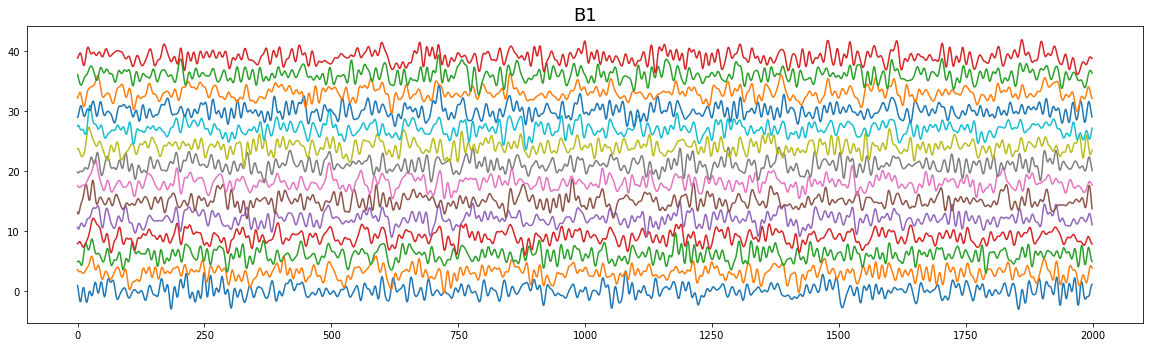

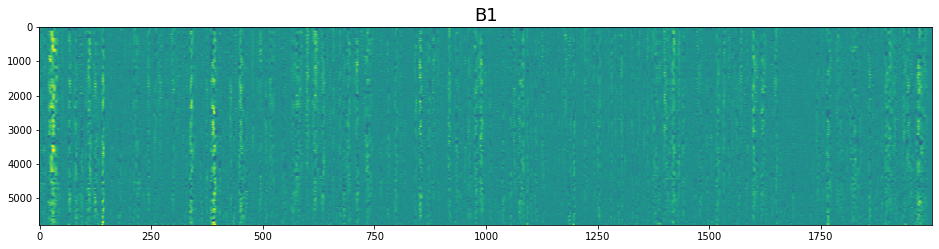

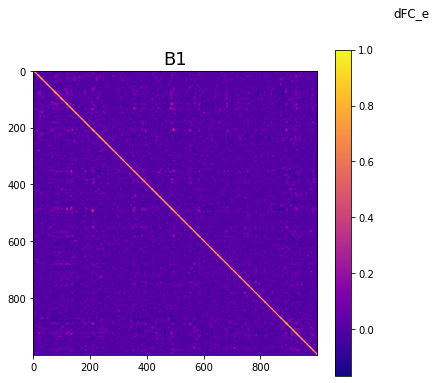

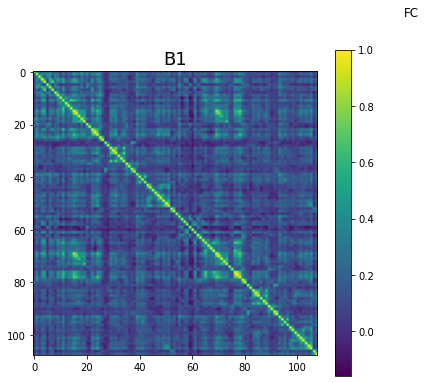

In [30]:
B1=B[5,:,:]
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.title('B1',fontsize=18)
for i in range(14):
    plt.plot(stats.zscore(B1[:,i])+3*i)
    
    
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.title('B1',fontsize=18)
plt.imshow(go_edge(B1).T,vmin=-5.,vmax=5.,aspect='auto')

plt.figure(figsize=(14,6))
plt.suptitle('dFC_e')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(go_edge(B1[500:1500,:])),cmap='plasma')
plt.colorbar()

plt.figure(figsize=(14,6))
plt.suptitle('FC')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(B1.T))
plt.colorbar()

In [60]:
B1=B[7,:,:]
nregions=B1.shape[1]
R=RSS(B1)
q=np.percentile(R,95)
top_B1=B1[(R>q),:]

FC=np.corrcoef(B1.T)
topFC=np.corrcoef(top_B1.T)
ind=np.triu_indices(nregions,k=1)
stats.pearsonr(FC[ind],topFC[ind])

(0.7035369854132302, 0.0)

In [62]:
B2=Bsim[7,0,:,:]
nregions=B2.shape[1]
R=RSS(B2)
q=np.percentile(R,95)
top_B2=B2[(R>q),:]

FC=np.corrcoef(B2.T)
topFC=np.corrcoef(top_B2.T)
ind=np.triu_indices(nregions,k=1)
stats.pearsonr(FC[ind],topFC[ind])

(0.7816426294207502, 0.0)

In [67]:
m=Bsim.shape[0]
p=Bsim.shape[1]
C=np.zeros((m,p))
for k in range(m):
    for j in range(p):
        B2=Bsim[k,j,:,:]
        nregions=B2.shape[1]
        R=RSS(B2)
        q=np.percentile(R,95)
        top_B2=B2[(R>q),:]

        FC=np.corrcoef(B2.T)
        topFC=np.corrcoef(top_B2.T)
        ind=np.triu_indices(nregions,k=1)
        if (np.isnan(FC).any())|(np.isnan(topFC).any()):
            C[k,j]=0
        else:    
            C[k,j]=stats.pearsonr(FC[ind],topFC[ind])[0]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(11, 4)
(11, 5)
(11, 6)
(11, 7)
(11, 8)
(11, 9)
(12, 0)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(12, 9)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 5)
(13, 6)
(13,

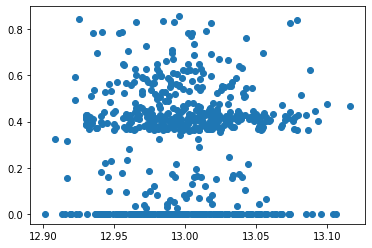

In [71]:
x = np.random.normal(i, 0.04, size=C.flatten().shape[0])
plt.scatter(x,C.flatten())